
# G2Net Playground TPU



This notebook has been created to serve as a guided tour to training G2Net models by using Colab TPU. The code **IS BASED** on the project-like tree uploaded to my GitHub as well, a code that rocketed the team (ROC & Roll) to top 8% and a bronze medal in its first competition. With all that said, let's ROC it! (Hope you get the joke)

## 1. Introduction

### 1.1 Problem Description

Not only a network of Gravitational Waves, Geophysics and Machine Learning experts, G2Net was also released as a Kaggle competition. I'm pretty sure that you have heard about the discovery of Gravitational Waves (GW), signals from colliding binary black holes, back in 2016. If not, you can refresh your memory with [The Sound of Two Black Holes Colliding](https://www.youtube.com/watch?v=QyDcTbR-kEA). 

The aim of this competition is to detect GW signals from the mergers of binary black holes. Specifically, the participant was expected to build a model to analyse synthetic GW time-series data from a network of Earth-based detectors (LIGO Hanford, LIGO Livingston and Virgo). The [Data](https://www.kaggle.com/c/g2net-gravitational-wave-detection/data) was simulated with a sampling rate of 2048 Hz. Each of the time-series originated by the corresponding detector comprises a channel (three in total).

In the context of this notebook, data has been already standardised (with training set mean and standard deviation), transposed (to ease channels last format) and saved to TensorFlow Records format. Such data can be found in my Kaggle profile, [Training Dataset](https://www.kaggle.com/salbeal94/g2net-float32-train) and [Test Dataset](https://www.kaggle.com/salbeal94/g2net-float32-test). Since it is a classification task, the output is the black hole merger occurence probability.

### 1.2 Implemented Model

After many iterations, the model used for the competition ended up being a 2D Convolutional Neural Network (CNN) preceded by a series of time-series processing techniques. Even the preprocessing has been here implemented as part of the model to stay loyal to the end-to-end philosophy. Such a model contains a series of building blocks several of them presented as trainable Tensorflow Keras layers. These are described as follows:
- **Tukey Window (trainable/non-trainable)**: Introduces a tappering effect that forces the signal amplitude to decay until having zero values at the ends. It is applied to avoid artefacts stemming from discontinuities when taking Fourier transforms or similar.

- **Bandpass Filter (trainable/non-trainable)**: Applies a filter with the frequency response of a Butterworth filter. The idea is to filter out or attenuate frequencies that have nothing to do with the merger.

- **Constant-Q Transform (trainable/non-trainable)**: Transforms the time-domain signal into the time-frequency domain. In other words, it converts a time-domain signal to a spectrogram. Particularly, the PyTorch CQT1992v2 implementation from [nnAudio](https://github.com/KinWaiCheuk/nnAudio) has been taken as reference. It has been re-implemented in TensorFlow for being one of the most cost-effective solutions offered by the library. As an additional functionality, the layer keeps track of maximum spectrogram magnitudes and normalises its values to a preset range for the sake of stability. The output spectrogram is later resized with bilinear interpolation to adapt it to the downstream CNN recommended input sizes.

- **Channel Permutation (non-trainable)**: Randomly decides whether to apply a stochastic permutation of the channels. The aim is to make the prediction a bit less independent of the detector it comes from, pressumably acting as a regularisation layer.

- **Spectral Masking (non-trainable)**: Randomly decides whether to stochastically mask certain time or frequency bands. Similar to the permutation, the idea is for this layer to act as a regularising operation.

- **Convolutional Neural Network (trainable/non-trainable)**: Used as backbone to extract the relevant features to be ingested by a single fully-connected neuron with sigmoid activation (after flattening). Given its performance-complexity trade-off in the ImageNet dataset, the EfficientNet family from [AutoML](https://github.com/google/automl) was selected as a more than appropriate model for this purpose.

![G2Net Model](https://github.com/salvaba94/G2Net/blob/main/img/Model.png?raw=true "G2Net Model")

## 2. Configuration

### 2.1 Environment Configuration

Before starting with implementation-specific details, let's configure some aspects of the environment: 

- Make sure the Colab environment type is set to TPU going to ```Runtime → Change runtime type → TPU```
- Mount your Google Drive to save any output model after the execution.
- Install any library that might be missing from the defaults.



In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [2]:
!pip install tensorflow-addons
!pip install adabelief-tf
!git clone https://github.com/google/automl.git automl-efficientnetv2/automl

     |████████████████████████████████| 1.1 MB 6.5 MB/s 
Cloning into 'automl-efficientnetv2/automl'...
remote: Enumerating objects: 4028, done.
remote: Counting objects: 100% (415/415), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 4028 (delta 246), reused 303 (delta 190), pack-reused 3613
Receiving objects: 100% (4028/4028), 25.30 MiB | 32.87 MiB/s, done.
Resolving deltas: 100% (2998/2998), done.


### 2.2 Code Configuration 


Now it is high time to start with the Python specifics. Run the following cell to import the necessary libraries for the code to work.

In [3]:
import sys
import os
import warnings
import copy
import pandas as pd
import numpy as np
import multiprocessing as mp
import tensorflow as tf
import seaborn as sns
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from adabelief_tf import AdaBeliefOptimizer
from datetime import datetime
from pathlib import Path, os
from functools import partial
from scipy import signal
from scipy import interpolate
from typing import Tuple, Union, Mapping
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

Set the configuration variables necessary for the code to run. Here is where you should come if you would like to play with the model. Don't worry if some of the variables are not clear enough at this point. Their utility can be derived as these are used all along the code.


In [4]:
class Config:
### General data #############################################################
    N_SAMPLES, N_DETECT = 4096, 3

### Training #################################################################
    FROM_TFR = False
    MODEL_TRAIN = True
    MODEL_SAVE_NAME = "Model_Ref.h5"
    MODEL_PRELOAD = False
    MODEL_PRELOAD_NAME = "Model_Ref.h5"
    HISTORY_NAME = "history_train.csv"

    MODEL_PATH = Path("models")
    CKPT_PATH = Path("checkpoints")

    SPLIT = 0.98
    SEED_SPLIT = 21
    BATCH_SIZE = 128
    BATCH_SIZE_TEST = 32
    EPOCHS = 1
    LEARNING_RATE = 0.0001
    
### Prediction ################################################################
    MODEL_PREDICT = True
    PREDICTIONS_NAME = "submission.csv"


### Model ####################################################################
    TUKEY_SHAPE = 0.25
    TRAINABLE_TUKEY = False

    DEGREE_FILT = 6
    F_BAND_FILT = (20., 500.)
    TRAINABLE_FILT = True

    SAMPLE_RATE = 2048
    F_BAND_SPEC = (20., 500.)
    HOP_LENGTH = 64
    BINS_PER_OCTAVE = 12
    WINDOW_CQT = "hann"
    TRAINABLE_CQT = False
    
    IMAGE_SIZE = 260

    P_PERM = 0.1

    P_MASK = 0.1
    N_MAX_MASK = 2
    W_MASK = (0, IMAGE_SIZE // 6)
    
    MODEL_ID = "efficientnetv2-b2"
    MODEL_ID_WEIGHTS = MODEL_ID

### Plotting #################################################################
    PLOT_EXAMPLE = True
    PLOT_TEST = False

To make use of TPUs, data ingested by the model should be stored in Google Cloud Storage (GCS) buckets. Fortunately, Kaggle is so integrated with Google that public datasets get uploaded to Google Cloud. To know their bucket addresses one should just run the following in a Kaggle notebook:
```
from kaggle_datasets import KaggleDatasets
MODEL_BUCK = KaggleDatasets().get_gcs_path("automl-efficientnetv2-ckpt")
TEST_PATH = KaggleDatasets().get_gcs_path("g2net-float32-test")
TRAIN_PATH = KaggleDatasets().get_gcs_path("g2net-float32-train")
```

The output addresses should be pasted below as raw strings (check them from time to time as they are periodically changed).

In [5]:
os.environ["MODEL_BUCK"] = r"gs://kds-b512e196d236dcc25f915f875eadb7bcfda6c3ce473349146c8cc4a4"
os.environ["TEST_BUCK"] = r"gs://kds-7f9c8748243b5c63ecfe7739ca8e1cdf5caa2106040be8c8ee1f603a"
os.environ["TRAIN_BUCK"] = r"gs://kds-3e8541897910bfef73ed5b5f448a5bab5df453506aa6d94488411a24"
MODEL_BUCK = os.environ["MODEL_BUCK"]
TEST_BUCK = os.environ["TEST_BUCK"]
TRAIN_BUCK = os.environ["TRAIN_BUCK"]

Run the next cell to tune the paths and add AutoML EfficientNet model paths to Python path.

In [6]:
OV_PATH = Path("/content")
SRC_PATH = str(Path(OV_PATH, "automl-efficientnetv2"))
CKT_PATH = MODEL_BUCK + "/" + Config.MODEL_ID_WEIGHTS
TRAIN_PATH = TRAIN_BUCK + "/train"
TEST_PATH = TEST_BUCK + "/test"

AUTOML_PATH = str(Path(SRC_PATH, "automl"))
EFFNETV2_PATH = str(Path(AUTOML_PATH, "efficientnetv2"))

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    sys.path.append(AUTOML_PATH)
    sys.path.append(EFFNETV2_PATH)
    
from automl.efficientnetv2 import effnetv2_model
from automl.efficientnetv2 import hparams
from automl.efficientnetv2 import effnetv2_configs
from automl.efficientnetv2 import utils

The following pair of cells automatically configures the TensorFlow strategy and device (relevant for TPU) and sets the data type to use.

In [7]:
class Acceleration(object):
    """
    General hardware acceleration class
    """

    @staticmethod
    def get_acceleration() -> None:
        """
        Function to get and configure the hardware acceleration. It will 
        sequentially try to configure TPU, GPU and CPU.
        """
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print("Device:", tpu.master())
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            device = "TPU"

        except:
            strategy = tf.distribute.get_strategy()
            device ="GPU" if "GPU" in [d.device_type for d in 
                                   device_lib.list_local_devices()] else "CPU"

        print(device, "Number of replicas:", strategy.num_replicas_in_sync)
        return strategy, device

In [8]:
# Create strategy and define data types for data and tensorflow models
strategy, device = Acceleration.get_acceleration()
dtype = tf.float32 # Do not modify since TF Records are in tf.float32

Device: grpc://10.40.205.18:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.40.205.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.205.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU Number of replicas: 8


Since each TF Record contains several examples (each with ID, time-domain signals and label if any), one might lose track of the number of examples in training and test sets. Actually, it needs to be known to figure out the number of steps per epoch. Such information is contained in two CSV that need to be locally stored. This is the purpose of the following lines.

In [9]:
!mkdir -p g2net-float32-train
!mkdir -p g2net-float32-test
!gsutil cp $TRAIN_BUCK/training_labels.csv g2net-float32-train
!gsutil cp $TEST_BUCK/sample_submission.csv g2net-float32-test

Copying gs://kds-3e8541897910bfef73ed5b5f448a5bab5df453506aa6d94488411a24/training_labels.csv...
/ [1 files][  6.9 MiB/  6.9 MiB]                                                
Operation completed over 1 objects/6.9 MiB.                                      
Copying gs://kds-7f9c8748243b5c63ecfe7739ca8e1cdf5caa2106040be8c8ee1f603a/sample_submission.csv...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


## 3. Source Code

### 3.1 Utilities

This section defines a pair of utility classes for general usage or plotting purposes. Sad as it is, there is nothing that should be really highlighted from here.

In [10]:
class GeneralUtilities(object):
    """
    General utilities class
    """

    @staticmethod
    def broadcast_dim(
            x: tf.Tensor
        ) -> tf.Tensor:
        """
        Auto broadcast input for tensorflow.

        Parameters
        ----------
        x : tf.Tensor
            Broadcasted tensor.

        Raises
        ------
        ValueError
            If input shape is not 1, 2 or 3.

        Returns
        -------
        x : tf.Tensor
            Broadcasted tensor.
        """
        rank = len(x.get_shape().as_list())

        if rank == 1:
            x = tf.expand_dims(tf.expand_dims(x, axis = 0), axis = -1)
        elif rank == 2:
            x = tf.expand_dims(x, axis = -1)
        elif rank == 3:
            pass
        else:
            raise ValueError("Only support input with shape = (n_batch, n_samples) \
                             or shape = (n_samples)")
        return x

In [11]:
class PlottingUtilities(object):
    """
    Plotting utilities class
    """

    time_tag = "Time [s]"
    freq_tag = "Frequency [Hz]"
    mag_tag = "Strain [-]"
    detector = ("LIGO Hanford", "LIGO Livingston", "Virgo")


    @classmethod
    def plot_wave(
            cls,
            waveforms: np.ndarray, 
            timespan: float = 2.
        ) -> None:
        """
        Function to plot waves from the 3 detectors.

        Parameters
        ----------
        waveforms : np.ndarray, shape = (n_samples, n_channels)
            Waveform data to plot.
        timespan : float, optional
            Time span of the waveforms [s]. The default is 2.
        """
        if waveforms.shape[-1] != 3:
            raise ValueError("Function expects exactly data for 3 detectors")

        time = np.linspace(0., timespan, waveforms.shape[0]) [:, np.newaxis]
        min_val, max_val = waveforms.min(), waveforms.max()
        dataframe = pd.DataFrame(data = np.hstack((time, waveforms)), 
                                 columns = [cls.time_tag, 
                                            cls.mag_tag + " " + cls.detector[0], 
                                            cls.mag_tag + " " + cls.detector[1], 
                                            cls.mag_tag + " " + cls.detector[2]])

        plt.style.use("seaborn")
        fig, axes = plt.subplots(3, 1, figsize = (15, 10))
        for i in range(len(cls.detector)):
            sns.lineplot(data = dataframe, x = cls.time_tag, 
                         y = cls.mag_tag + " " + cls.detector[i], ax = axes[i])
            axes[i].legend([cls.detector[i]])
            axes[i].set_ylabel(cls.mag_tag)
            axes[i].set_ylim(min_val, max_val)
    

    @classmethod
    def plot_spectrogram(
            cls,
            spectrogram: np.ndarray,
            **kwargs
        ) -> None:
        """
        Function to plot a spectrogram.

        Parameters
        ----------
        spectrogram : np.ndarray, shape = (n_freq, n_time, n_channels)
            Spectrogram data.
        """
        if spectrogram.shape[-1] != 3:
            raise ValueError("Function expects exactly data for 3 detectors")

        plt.style.use("seaborn")
        fig, axes = plt.subplots(1, len(cls.detector), figsize = (15, 5))
        for i in range(len(cls.detector)):
            librosa.display.specshow(data = spectrogram[..., i], 
                                     ax = axes[i], **kwargs)
            axes[i].set_xlabel(cls.time_tag)
            axes[i].set_ylabel(cls.freq_tag)
            axes[i].set_title(cls.detector[i])
      

### 3.2 Data Ingestion

The following class implements the logic to serialise/deserialise TensorFlow Records for this problem. A target argument controls whether the dataset is used for training/validation or test/prediction. The examples contained should be deserialised by creating a TensorFlow Datasets pipeline.

In [12]:
class TFRDatasetCreator(object):
    """
    Class to aid in the creation of tensorflow records datasets
    """

    def __init__(
            self,
            dataframe: pd.DataFrame,
            datadir: Path,
            trans: bool = False,
            data_stats: Tuple[float, float] = None,
            raw_dir: bool = False,
            ext_in: str = ".npy",

        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        dataframe : pd.DataFrame, columns = (id, targets)
            Dataframe with the indeces of the samples.
        datadir : Path
            Data directory.
        trans : bool, optional
            Whether the to transpose the data before storing. The default is 
            False.
        data_stats : Tuple[float, float], optional
            If provided, these are used to standardise the input data. It 
            contains mean and standard deviation in this order. The default is None.
        raw_dir : bool
            Whether the folder should be treated as a raw data folder directory.
            The default is False.
        ext_in : str, optional
            Extension of the input files. The default is ".npy".
        """

        self.df = dataframe.copy()
        self.datadir = datadir
        self.data_stats = data_stats
        self.trans = trans

        if raw_dir:
            self.df["path"] = str(datadir) + os.sep + dataframe["id"].apply(
                lambda x: x[0]) + os.sep + dataframe["id"].apply(
                lambda x: x[1]) + os.sep + dataframe["id"].apply(
                lambda x: x[2]) + os.sep + dataframe["id"].astype(str) + ext_in
        else:
            self.df["path"] = str(datadir) + os.sep + dataframe["id"].astype(str) + ext_in


    @staticmethod
    def _bytes_feature(
            value: Union[np.ndarray, tf.Tensor, str]
        ) -> tf.train.Feature:
        """
        Function to convert an array, string or tensor to a list of bytes feature

        Parameters
        ----------
        value : Union[np.ndarray, tf.Tensor, str]
            Input value to convert to a list of bytes feature.

        Returns
        -------
        tf.train.Feature
            The converted feature.
        """

        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))


    @staticmethod
    def _int_feature(
            value: Union[int, bool]
        ) -> tf.train.Feature:
        """
        Function to convert a bool / enum / int / uint to an int feature.
        
        Parameters
        ----------
        value : Union[int, bool]
            Input value to convert to an int feature.
        
        Returns
        -------
        tf.train.Feature
            The converted feature.
        """

        return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


    def _serialize_example(
            self, 
            idx: int,
            dtype: type = tf.float32
        ) -> str:
        """
        Method to serialise a single example.
        
        Parameters
        ----------
        idx : int
            ID of the example to selialize.
        dtype : type, optional
            Data type to which the example should be serialised. The default 
            is tf.float32.

        Returns
        -------
        str
            Serialised example.
        """

        data = np.load(self.df["path"][idx])
        identity = self.df["id"][idx]
        target = self.df["target"][idx]

        data = data.T if self.trans else data
        
        if self.data_stats is not None:
            data = (data - self.data_stats[0]) / self.data_stats[-1] 

        data = tf.convert_to_tensor(data, dtype = dtype)

        feature = {
            "data": self._bytes_feature(tf.io.serialize_tensor(data)),
            "id": self._bytes_feature(identity.encode()),
            "target": self._int_feature(np.int(target))
        }
        
        example = tf.train.Example(features = tf.train.Features(feature = feature))
        return example.SerializeToString()


    def _serialize_batch(
            self,
            data: Tuple[int, np.ndarray],
            destdir: Path,
            dtype: type = tf.float32,
            filename: str = "train",
            ext_out: str = ".tfrec"
        ) -> None:
        """
        Method to serialise a batch of examples and write it to tensorflow record.
        
        Parameters
        ----------
        data : Tuple[int, np.ndarray]
            Batch data. Contains batch ID and array of examples to be serialised,
            respectively.
        destdir : Path
            Destination directory.
        dtype : type, optional
            Data type to which the examples should be serialised. The default 
            is tf.float32.
        filename : str, optional
            Filename of the output tensorflow record. To it, the batch ID and 
            the range of the examples contained in it will be appended. 
            The default is "train".
        ext_out : str, optional
            Extension of the output files. The default is ".tfrec".
        """

        n_batch, batch = data
        filename_batch = destdir.joinpath(filename + str(n_batch).zfill(3) 
                                          + "-" + str(batch.shape[0]) + ext_out)
        with tf.io.TFRecordWriter(str(filename_batch)) as writer:
            for idx in batch:
                writer.write(self._serialize_example(idx, dtype = dtype))



    def serialize_dataset(
            self,
            n_samples,
            destdir: Path,
            dtype: type = tf.float32,
            filename: str = "train",
            ext_out: str = ".tfrec"
        ) -> None:
        """
        Method to serialise a the full dataset and write it to a set of 
        tensorflow records.
        
        Parameters
        ----------
        n_samples : int
            Number of samples used to calculate the number of tensorflow 
            records files.
        destdir : Path
            Destination directory.
        dtype : type, optional
            Data type to which the examples should be serialised. The default 
            is tf.float32.
        filename : str, optional
            Filename of the output tensorflow record. The default is "train".
        ext_out : str, optional
            Extension of the output files. The default is ".tfrec".
        """

        destdir.mkdir(parents = True, exist_ok = True)

        n_files = np.int32(np.ceil(self.df.shape[0] / n_samples))

        for n_batch, batch in enumerate(np.array_split(self.df.index, n_files)): 
            print("Writing TFRecord " + str(n_batch) + " with files from " + 
                  str(batch[0]) + " to " + str(batch[-1]))
            writer = partial(self._serialize_batch, destdir = destdir, 
                         dtype = dtype, filename = filename, ext_out = ext_out)
            writer((n_batch, batch))


    @staticmethod
    def deserialize_example(
            element,
            dtype: type = tf.float32,
            target: bool = False,
            shape: Tuple[int, int] = (4096, 3)
        ) -> Tuple[tf.Tensor, int]:
        """
        Method intended to be used in any dataset generator to deserialise the 
        examples from tensorflow records.
        
        Parameters
        ----------
        element : int
            Serialised example.
        dtype : type, optional
            Data type to which the example was serialised. The default is tf.float32.
        target : bool, optional
            Whether the label should be included in the output. If false, it is 
            interpreted that the aim is to predict and, therefore, the ID of the 
            example is appended instead. The default is False.
        shape : Tuple[int, int], optional
            Shape to which the example data should be reshaped 
        
        Returns
        -------
        Tuple[tf.Tensor, int]
            Example data and label or ID, depending on the value of target argument.
        """

        feature = {
            "data"  : tf.io.FixedLenFeature([], tf.string),
            "id" : tf.io.FixedLenFeature([], tf.string),
            "target" : tf.io.FixedLenFeature([], tf.int64)
        }

        content = tf.io.parse_single_example(element, feature)
 
        data = content["data"]
        data = tf.io.parse_tensor(data, out_type = dtype)
        data = tf.reshape(data, shape = shape)

        idx = tf.cast(tf.strings.unicode_decode(content["id"], "UTF-8"), 
                      dtype = tf.int32)
        label = tf.cast(content["target"] , dtype)
        
        if target:
            return data, label
        else:
            return data, idx

In [13]:
class DatasetGeneratorTF(object):
    """
    Class to aid in the creation of dataset pipelines using tensorflow
    """

    def __init__(
            self,
            dataframe: pd.DataFrame,
            datadir: Path,
            batch_size: int = 64,
            dtype: type = tf.float32,
            raw_dir: bool = False,
            ext: str = ".tfrec"
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        dataframe : pd.DataFrame, columns = (id, targets)
            Dataframe with the indeces of the samples.
        datadir : Path
            Data directory.
        batch_size : int, optional
            Batch size. The default is 32.
        dtype : type, optional
            Data type to use. The default is np.float16.
        raw_dir : bool
            Whether the folder should be treated as a raw data folder directory.
            The default is False.
        ext : str, optional
            Extension of the files. The default is ".tfrec".
        """

        self.df = dataframe.copy()
        self.datadir = datadir
        self.batch_size = batch_size
        self.dtype = dtype

        if raw_dir:
            self.df["path"] = str(datadir) + os.sep + dataframe["id"].apply(
                lambda x: x[0]) + os.sep + dataframe["id"].apply(
                lambda x: x[1]) + os.sep + dataframe["id"].apply(
                lambda x: x[2]) + os.sep + dataframe["id"].astype(str) + ext
        else:
            self.df["path"] = str(datadir) + os.sep + dataframe["id"].astype(str) + ext


    def _read_npy(
            self, 
            filename: Path
        ) -> np.ndarray:
        """
        Auxiliary method to read data from npy file.

        Parameters
        ----------
        filename : Path
            Path and name of the example to read.

        Returns
        -------
        np.ndarray
            Data from the file.
        """

        example_data = tf.cast(np.load(filename), self.dtype)
        return example_data


    def _get_dataset_from_npy(
            self,
            shuffle: bool = True,
            buffer_size: int = 1024,
            repeat: bool = True,
            target: bool = True
        ) -> tf.data.Dataset:
        """
        Function to get the dataset pipeline from npy files.

        Parameters
        ----------
        shuffle : bool, optional
            Whether to add shuffle to the pipeline or not. The default is True.
        buffer_size : int, optional
            Shuffle buffer size. The default is 1024.
        repeat : bool, optional
            Whether to repeat the dataset or not. The default is True
        target : bool, optional
            Whether to add the label or not. The default is True.

        Returns
        -------
        tf.data.Dataset
            Dataset pipeline.
        """

        feature_ds = tf.data.Dataset.from_tensor_slices(self.df["path"])
        feature_ds = feature_ds.map(lambda x: tf.numpy_function(
            self._read_npy, [x], self.dtype), 
            num_parallel_calls = AUTOTUNE)

        if target:
            label_ds = tf.data.Dataset.from_tensor_slices(self.df["target"])
            ds = tf.data.Dataset.zip((feature_ds, label_ds))
        else:
            ds = feature_ds

        if shuffle:
            ds = ds.shuffle(buffer_size)
        
        if repeat:
            ds = ds.repeat()

        ds = ds.batch(self.batch_size)
        return ds.prefetch(AUTOTUNE)


    def _get_dataset_from_tfrec(
            self,
            shuffle: bool = True,
            buffer_size: int = 1024,
            ordered: bool = False,
            repeat: bool = True,
            target: bool = True
        ) -> tf.data.Dataset:
        """
        Function to get the dataset pipeline from tensorflow records.

        Parameters
        ----------
        shuffle : bool, optional
            Whether to add shuffle to the pipeline or not. The default is True.
        buffer_size : int, optional
            Shuffle buffer size. The default is 1024.
        ordered: bool, optional
            Indicate whether the order matters when reading. The default is False.
        repeat : bool, optional
            Whether to repeat the dataset or not. The default is True.
        target : bool, optional
            Whether to add the label or not. The default is True.
        
        Returns
        -------
        tf.data.Dataset
            Dataset pipeline.
        """

        ds = tf.data.TFRecordDataset(self.df["path"], num_parallel_reads = AUTOTUNE)

        if not ordered:
            ignore_order = tf.data.Options()
            ignore_order.experimental_deterministic = False
            ds = ds.with_options(ignore_order)

        ds = ds.map(lambda x: TFRDatasetCreator.deserialize_example(
            x, dtype = self.dtype, target = target, shape = (Config.N_SAMPLES, 
            Config.N_DETECT)), num_parallel_calls = AUTOTUNE)

        if shuffle:
            ds = ds.shuffle(buffer_size)

        if repeat:
            ds = ds.repeat()
        
        ds = ds.batch(self.batch_size, drop_remainder = target)
        return ds.prefetch(AUTOTUNE)


    def get_dataset(
            self,
            tfrec: bool = True, 
            shuffle: bool = True,
            buffer_size: int = 1024,
            ordered: bool = False,
            repeat: bool = True,
            target: bool = True
        ) -> tf.data.Dataset:
        """
        Function to get the dataset pipeline.

        Parameters
        ----------
        tfrec : bool, optional
            Whether TFRecord should be read or not. The default is True.
        shuffle_buffer : int, optional
            Shuffle buffer size. If None, no shuffle will be applied. The default 
            is 3200.
        ignore_order : bool, optional
            Dataframe with the indeces of the samples. The default is True.

        Returns
        -------
        tf.data.Dataset
            Dataset pipeline.
        """
        
        ret_val = self._get_dataset_from_tfrec(shuffle, buffer_size, ordered,
            repeat, target) if tfrec else self._get_dataset_from_npy(
            shuffle, buffer_size, repeat, target)
        return ret_val

### 3.3 Custom Model

#### 3.3.1 Custom Preprocessing Layers

The following lines implement the building blocks of the model that are not built-in in TensorFlow or provided by third parties. In the case of preprocessing layers, the Tukey window and the bandpass filter are included.

In [14]:
class TukeyWinLayer(tf.keras.layers.Layer):
    """
    Layer that applies a Tukey window function to an input time series, where 
    the possibility of training the shape parameter is given. Not usable with TPU.
    """

    def __init__(
            self, 
            initial_alpha: float = 0.25,
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        initial_alpha : float, optional
            Shape parameter of the tukey window. The default is 0.25.
        """
    
        super(TukeyWinLayer, self).__init__(**kwargs)

        self.alpha = tf.Variable(initial_value = initial_alpha, 
                                 trainable = self.trainable,
                                 name = self.name + "/alpha", 
                                 dtype = self.dtype)


    def build(
            self, 
            input_shape: Tuple[int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters.

        Parameters
        ----------
        input_shape : Tuple[int, int]
            Shape of the input to the layer.
        """

        if self.trainable:
            self.trainable_weights.append(self.alpha)
        else:
            self.non_trainable_weights.append(self.alpha)
        super(TukeyWinLayer, self).build(input_shape)


    def call(
            self, 
            data: tf.Tensor
        ) -> tf.Tensor:
        """
        Forward pass of the layer.

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_samples, n_detectors)
            A batch of input waveforms, n_detectors (n_channels) should 
            be last.

        Returns
        -------
        tf.Tensor, shape = (None, n_samples, n_detectors)
            The corresponding batch of windowed signals.
        """

        x = GeneralUtilities.broadcast_dim(data)
        x = tf.cast(x, self.dtype)
        w_len = tf.shape(x)[1]
        window = GeneralUtilities.broadcast_dim(self._get_window(w_len))
        x *= window
        return x


    def _get_ones(
            self,
            w_len: int
        ) -> tf.Tensor:
        """
        Case for a null shape parameter.

        Parameters
        ----------
        w_len : int
            Length of the window.

        Returns
        -------
        tf.Tensor : shape = (window_len,)
            A window of all ones.
        """
 
        window = tf.ones(w_len, dtype = self.dtype)
        return window

        
    def _get_hann(
            self,
            w_len: int
        ) -> tf.Tensor:
        """
        Case for a unity shape parameter.

        Parameters
        ----------
        w_len : int
            Length of the window.

        Returns
        -------
        tf.Tensor : shape = (window_len,)
            A hann window.
        """
 
        window = tf.signal.hann_window(w_len, periodic = False)
        window = tf.cast(window, dtype = self.dtype)
        return window


    def _get_tukey(
            self,
            w_len: int
        ) -> tf.Tensor:
        """
        Case for a non-null and non-unity shape parameter.

        Parameters
        ----------
        w_len : int
            Length of the window.

        Returns
        -------
        tf.Tensor : shape = (window_len,)
            A tukey window.
        """
 
        w_len_f = tf.cast(w_len, self.dtype)
       
        n = tf.range(0, w_len)
        width = tf.math.floor(self.alpha * (w_len_f - 1.)/2.)
        width = tf.minimum(width, w_len_f)
        width = tf.maximum(width, 0.)
        width = tf.cast(width, dtype = tf.int32)

        n_1 = tf.cast(n[:width + 1], dtype = self.dtype)
        n_2 = tf.cast(n[width + 1: w_len - width - 1], dtype = self.dtype)
        n_3 = tf.cast(n[w_len - width - 1:], dtype = self.dtype)
    
        window_1 = 0.5 * (1. + tf.math.cos(np.pi * (
            -1. + 2. * n_1 / self.alpha / (w_len_f - 1.))))
        window_2 = tf.ones(tf.shape(n_2))
        window_3 = 0.5 * (1. + tf.math.cos(np.pi * (
            - 2./self.alpha + 1. + 2. * n_3 / self.alpha / (w_len_f - 1.))))
    
        window = tf.concat((window_1, window_2, window_3), axis = 0)
        return window
    
    
    def _get_window(
            self,
            w_len: int
        ) -> tf.Tensor:
        """
        Tukey window getter.

        Parameters
        ----------
        w_len : int
            Length of the window.

        Returns
        -------
        tf.Tensor : shape = (window_len,)
            A tukey window handling the cases of null or unity shape parameters.
        """

        get_ones = partial(self._get_ones, w_len = w_len + 1)
        get_hann = partial(self._get_hann, w_len = w_len + 1)
        get_tukey = partial(self._get_tukey, w_len = w_len + 1)

        window = tf.case([(tf.less_equal(self.alpha, 0.), get_ones),
                          (tf.greater_equal(self.alpha, 1.), get_hann)], 
                         default = get_tukey)
        window = window[:-1]
        return window

In [15]:
class WindowingLayer(tf.keras.layers.Layer):
    """
    Layer that applies a window function to an input time series.
    """

    def __init__(
            self, 
            window: Union[str, Tuple[str, float]] = ("tukey", 0.1),
            window_len: int = 4096,
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        window : str or Tuple[str, float], optional
            The type of window to create with any parameter it might need. 
            The default is "tukey" with alpha 0.1.
        window_len : int, optional
            The number of samples in the window (set it to the signal length). 
            The default is 4096.
        """
    
        super(WindowingLayer, self).__init__(**kwargs)

        self.window = window
        self.window_len = window_len

        sig = signal.get_window(window, window_len)[np.newaxis, :, np.newaxis]
        self.window = tf.Variable(initial_value = sig, trainable = self.trainable,
                                  name = self.name + "/window", dtype = self.dtype)


    def build(
            self, 
            input_shape: Tuple[int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters.
        
        Parameters
        ----------
        input_shape : Tuple[int, int]
            Shape of the input to the layer.
        """

        if self.trainable:
            self.trainable_weights.append(self.window)
        else:
            self.non_trainable_weights.append(self.window)
        super(WindowingLayer, self).build(input_shape)


    def call(
            self, 
            data: tf.Tensor
        ) -> tf.Tensor:
        """
        Forward pass of the layer.

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_samples, n_detectors)
            A batch of input mono waveforms, n_detectors (n_channels) should 
            be last.

        Returns
        -------
        tf.Tensor, shape = (None, n_samples, n_detectors)
            The corresponding batch of windowed waveforms.
        """

        x = GeneralUtilities.broadcast_dim(data)
        x = tf.cast(x, self.dtype)
        x *= self.window
        return x


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "window" : self.window,
            "window_len" : self.window_len
        }
        
        config.update(super(WindowingLayer, self).get_config())
        return config

In [16]:
class BandpassLayer(tf.keras.layers.Layer):
    """
    Layer that applies a bandpass Butterworth filter in the frequency domain, 
    where the possibility of training frequency response from the filter is 
    given.
    """

    def __init__(
            self, 
            sample_rate: float = 2048.,
            degree: int = 8,
            f_band: Tuple[float, float] = (20., 500.),
            n_samples: int = 4096,
            **kwargs
        ) -> None:
        """
        Funtion to initialize the object.

        Parameters
        ----------
        sample_rate : float, optional
            The sampling rate for the input time series [Hz]. It is used to 
            calculate the correct "f_min" and "f_max". The default is 2048.
        degree : int, optional
            Degree of the Butterworth filter. The default is 8.
        f_band : Tuple[float, float], optional
            The frequency band for the bandpass filter [Hz]. 
            The default is (20., 500). 
        n_samples : int, optional
            Number of samples of the signal to filter. The default is 4096.
        """
    
        super(BandpassLayer, self).__init__(**kwargs)
        
        self.sample_rate = sample_rate
        self.degree = degree
        self.f_band = f_band
        self.n_samples = n_samples

        if f_band[-1] <= f_band[0]:
            raise ValueError("Maximum frequency in spectral band should be \
                             higher than minimum frequency")

        f_nyq = sample_rate / 2.
        f_min = f_band[0] / f_nyq
        f_max = f_band[-1] / f_nyq
        self.norm = tf.constant(np.sqrt((f_band[-1] - f_band[0]) / f_nyq), 
                                dtype = self.dtype)

        f_fft = np.fft.rfftfreq(n_samples, d = 1./sample_rate)

        b, a = signal.butter(degree, (f_min, f_max), btype = "bandpass")
        w, gain = signal.freqz(b, a, worN = 2 * f_fft.shape[0])
        f = (f_nyq / np.pi) * w
        gain = np.abs(gain)

        gain_f = interpolate.interp1d(f, gain, fill_value = "extrapolate")
        f_response = gain_f(f_fft)
        f_response = f_response[np.newaxis, :]

        self.f_response = tf.Variable(initial_value = f_response, 
                                 trainable = self.trainable,
                                 name = self.name + "/f_response", 
                                 dtype = self.dtype)


    def build(
            self, 
            input_shape: Tuple[int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters.

        Parameters
        ----------
        input_shape : Tuple[int, int]
            Shape of the input to the layer.
        """

        if self.trainable:
            self.trainable_weights.append(self.f_response)
        else:
            self.non_trainable_weights.append(self.f_response)
        super(BandpassLayer, self).build(input_shape)


    def call(
            self, 
            data: tf.Tensor
        ) -> tf.Tensor:
        """
        Forward pass of the layer.

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_samples, n_detectors)
            A batch of input waveforms, n_detectors (n_channels) should 
            be last.

        Returns
        -------
        tf.Tensor, shape = (None, n_samples, n_detectors)
            The corresponding batch of bandpassed signals.
        """

        data_ref = GeneralUtilities.broadcast_dim(data)
        bandpass = []
        for i in range(data_ref.get_shape()[-1]):
            x = data_ref[..., i]
            x = tf.cast(x, self.dtype)
            spec = tf.signal.rfft(x)
            spec *= tf.cast(self.f_response, tf.complex64)
            x = tf.signal.irfft(spec)
            x = tf.cast(x, self.dtype)
            x = tf.expand_dims(x, axis = -1)
            bandpass = x if (i == 0) else tf.concat([bandpass, x], axis = -1)
        
        bandpass /= self.norm
        return bandpass


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "sample_rate": self.sample_rate,
            "degree": self.degree,
            "f_band": self.f_band,
            "n_samples": self.n_samples
        }

        config.update(super(BandpassLayer, self).get_config())
        return config

#### 3.3.2 Custom Regularisation/Augmentation Layers

Regularisation layers include, in this case, channels permutation and any form of spectrogram masking.

In [17]:
class PermuteChannel(tf.keras.layers.Layer):
    """
    Layer that randomly permutes the channels from data to avoid overfitting 
    in the context of G2Net.
    """

    def __init__(
            self, 
            p: float = 0.1,
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        rate : float, optional
            Probability of performing a permutation. The default 0.5.
        """
    
        super(PermuteChannel, self).__init__(**kwargs)
        self.p = p


    def build(
            self, 
            input_shape: Tuple[int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters if any.

        Parameters
        ----------
        input_shape : Tuple[int, int]
            Shape of the input to the layer.
        """

        super(PermuteChannel, self).build(input_shape)



    def call(
            self, 
            data: tf.Tensor,
            training: bool = None
        ) -> tf.Tensor:
        """
        Forward pass of the layer (requires channels to be last).

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_samples, n_detectors)
            A batch of channeled inputs, n_detectors (n_channels) should be last.
        training : bool, optional
            Whether the forward pass is called in training or in prediction 
            mode. Default is None.

        Returns
        -------
        tf.Tensor, shape = (None, n_samples, n_detectors)
            The corresponding batch of channeled inputs.
        """

        x = data
        if training:
            x = tf.cond(tf.random.uniform(()) < self.p, 
                        partial(self._permute_channels, data = x),
                        lambda: tf.cast(x, self.dtype))
        return x


    def _permute_channels(
            self,
            data: tf.Tensor
        ) -> tf.Tensor:
        """
        This funtion applies a random permutations of the channels dimension 
        assuming channels last format.

        Parameters
        ----------
        data : tf.Tensor
            Input data.

        Returns
        -------
        tf.Tensor
            Permuted output data.
        """
    
        x = tf.cast(data, self.dtype)
        perm = tf.range(data.get_shape()[-1])
        perm = tf.random.shuffle(perm)
        return tf.gather(x, perm, axis = -1)


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "p" : self.p
        }
        
        config.update(super(PermuteChannel, self).get_config())
        return config

In [18]:
class _UtilitiesAug(object):
    """ 
    Utilities class for augmentations/regularisations
    """

    @staticmethod
    def time_mask(
            data: tf.Tensor, 
            param: tf.Tensor
        ) -> tf.Tensor:
        """
        Apply masking to a spectrogram in the time domain. Assumes batch 
        as the first dimension and channels as the last dimension.
        
        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Input spectrogram.
        param: int
            Parameter of time masking indicative of width.
        
        Returns
        -------
        tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Masked spectrogram.
        """
        _, freq_max, time_max, _ = data.get_shape()

        t0 = tf.random.uniform((), maxval = time_max - param, dtype = tf.int32)

        indices = tf.reshape(tf.range(time_max), (1, -1))
        condition = tf.math.logical_and(tf.math.greater_equal(indices, t0), 
                                       tf.math.less(indices, t0 + param))

        mask = tf.ones([freq_max, time_max], dtype = data.dtype)
        mask = tf.where(condition, tf.cast(0., data.dtype), mask)
        mask = tf.expand_dims(tf.expand_dims(mask, axis = 0), axis = -1)
        return data * mask


    @staticmethod
    def freq_mask(
            data: tf.Tensor, 
            param: tf.Tensor
        ) -> tf.Tensor:
        """
        Apply masking to a spectrogram in the frequency domain. Assumes batch 
        as the first dimension and channels as the last dimension.
    
        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Input spectrogram.
        param: tf.Tensor, shape = ()
            Parameter of frequency masking indicative of width.
    
        Returns
        -------
        tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Masked spectrogram.
        """
    
        _, freq_max, time_max, _ = data.get_shape()
    
        f0 = tf.random.uniform((), maxval = time_max - param, dtype = tf.int32)
    
        indices = tf.reshape(tf.range(freq_max), (-1, 1))
        condition = tf.math.logical_and(tf.math.greater_equal(indices, f0), 
                                       tf.math.less(indices, f0 + param))
    
        mask = tf.ones([freq_max, time_max], dtype = data.dtype)
        mask = tf.where(condition, tf.cast(0., data.dtype), mask)
        mask = tf.expand_dims(tf.expand_dims(mask, axis = 0), axis = -1)
        return data * mask

In [19]:
class SpectralMask(tf.keras.layers.Layer):
    """
    Layer that applies spectral masks to an input spectrogram. Not usable with TPU.
    """

    def __init__(
            self, 
            p: float = 0.2,
            n_max_mask_t: int = 2,
            w_mask_t: Tuple[int, int] = (5, 10),
            n_max_mask_f: int = 2,
            w_mask_f: Tuple[int, int] = (5, 10),
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        p : float, optional
            Probability of applying a spectral mask. The default 0.2.
        n_max_mask_t : int, optional
            Maximum number of masks in time dimension. The default is 2.
        n_max_mask_f : int, optional
            Maximum number of masks in frequency dimension. The default is 2.
        """
    
        super(SpectralMask, self).__init__(**kwargs)
        self.p = p
        self.n_max_mask_t = tf.math.maximum(n_max_mask_t, 0)
        self.w_min_mask_t = tf.math.maximum(w_mask_t[0], 1)
        self.w_max_mask_t = tf.math.maximum(w_mask_t[-1], 1)
        self.n_max_mask_f = tf.math.maximum(n_max_mask_f, 0)
        self.w_min_mask_f = tf.math.maximum(w_mask_f[0], 1)
        self.w_max_mask_f = tf.math.maximum(w_mask_f[-1], 1)


    def build(
            self, 
            input_shape: Tuple[int, int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters if any.

        Parameters
        ----------
        input_shape : Tuple[int, int, int]
            Shape of the input to the layer.
        """

        super(SpectralMask, self).build(input_shape)



    def call(
            self, 
            data: tf.Tensor,
            training: bool = None
        ) -> tf.Tensor:
        """
        Forward pass of the layer (requires channels to be last).

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_time, n_freq, n_detectors)
            A batch of channeled inputs, n_detectors (n_channels) should be last.
        training : bool, optional
            Whether the forward pass is called in training or in prediction 
            mode. Default is None.

        Returns
        -------
        tf.Tensor, shape = (None, n_time, n_freq, n_detectors)
            The corresponding batch of channeled inputs.
        """

        x = data
        if training:
            x = tf.cond(tf.random.uniform(()) < self.p, 
                        partial(self._apply_all_mask, data = x),
                        lambda: tf.cast(x, self.dtype))
        return x


    def _apply_single_mask_freq(
            self,
            i: int,
            i_max: int,
            data: tf.Tensor,
        ) -> tf.Tensor:
        """
        This funtion applies a single frequency spectral mask to a spectrogram. 
        Assumes batch as the first dimension and channels as the last dimension.
    
        Parameters
        ----------
        i : int
            Counter of the number of masks applied.
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Input data.
    
        Returns
        -------
        tf.Tensor
            Permuted output data.
        """

        w_mask = tf.random.uniform(shape = (), minval = self.w_min_mask_f, 
                                   maxval = self.w_max_mask_f + 1, dtype = tf.int32)
        x = data
        x = tf.cond(i < i_max, partial(_UtilitiesAug.freq_mask, param = w_mask, data = x), 
                    partial(_UtilitiesAug.freq_mask, param = 0, data = x))
        return i + 1, i_max, x
    

    def _apply_single_mask_time(
            self,
            i: int,
            i_max: int,
            data: tf.Tensor,
        ) -> tf.Tensor:
        """
        This funtion applies a single temporal spectral mask to a spectrogram. 
        Assumes batch as the first dimension and channels as the last dimension.
    
        Parameters
        ----------
        i : int
            Counter of the number of masks applied.
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Input data.
    
        Returns
        -------
        tf.Tensor
            Permuted output data.
        """
    
        w_mask = tf.random.uniform(shape = (), minval = self.w_min_mask_t, 
                                   maxval = self.w_max_mask_t + 1, dtype = tf.int32)
        x = data
        x = tf.cond(i < i_max, partial(_UtilitiesAug.time_mask, param = w_mask, data = x), 
                    partial(_UtilitiesAug.time_mask, param = 0, data = x))
        return i + 1, i_max, x


    def _apply_all_mask(
            self,
            data: tf.Tensor
        ) -> tf.Tensor:
        """
        This funtion applies all spectral masks to an input spectrogram 
        according to configuration. Assumes batch as the first dimension and 
        channels as the last dimension.

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            Input data.

        Returns
        -------
        tf.Tensor
            Masked output data.
        """
    
        n_mask_t = tf.random.uniform(shape = (), maxval = self.n_max_mask_t + 1, 
                                      dtype = tf.int32)
        n_mask_f = tf.random.uniform(shape = (), maxval = self.n_max_mask_f + 1, 
                                      dtype = tf.int32)

        x = data
        x = tf.cast(x, self.dtype)
        x = tf.while_loop(lambda i, i_max, inp: i < self.n_max_mask_t, 
                  self._apply_single_mask_time, (0, n_mask_t, x),
                  maximum_iterations = self.n_max_mask_t)[-1]
        x = tf.while_loop(lambda i, i_max, inp: i < self.n_max_mask_f, 
                  self._apply_single_mask_freq, (0, n_mask_f, x),
                  maximum_iterations = self.n_max_mask_f)[-1]
        return x


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "p" : self.p,
            "n_max_mask_t" : self.n_max_mask_t,
            "w_mask_t" : self.w_mask_t,
            "n_max_mask_f" : self.n_max_mask_t,
            "w_mask_f" : self.w_mask_t
        }
        
        config.update(super(SpectralMask, self).get_config())
        return config

In [20]:
class TimeMask(tf.keras.layers.Layer):
    """
    Layer that applies a single time mask to an input spectrogram.
    """

    def __init__(
            self, 
            p: float = 0.2,
            w_mask: Tuple[int, int] = (5, 10),
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        p : float, optional
            Probability of applying a spectral mask. The default 0.2.
        w_mask : Tuple[int, int], optional
            Minimum and maximum width of the mask in pixels. The default is (5, 10).
        """
    
        super(TimeMask, self).__init__(**kwargs)
        self.p = tf.constant(p, self.dtype)
        self.w_min_mask = tf.math.maximum(w_mask[0], 1)
        self.w_max_mask = tf.math.maximum(w_mask[-1], 1)


    def build(
            self, 
            input_shape: Tuple[int, int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters if any.

        Parameters
        ----------
        input_shape : Tuple[int, int, int]
            Shape of the input to the layer.
        """

        super(TimeMask, self).build(input_shape)



    def call(
            self, 
            data: tf.Tensor,
            training: bool = None
        ) -> tf.Tensor:
        """
        Forward pass of the layer (requires channels to be last).

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            A batch of channeled inputs, n_detectors (n_channels) should be last.
        training : bool, optional
            Whether the forward pass is called in training or in prediction 
            mode. Default is None.

        Returns
        -------
        tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            The corresponding batch of channeled inputs.
        """

        x = data
        if training:
            w_mask = tf.random.uniform(shape = (), minval = self.w_min_mask, 
                                       maxval = self.w_max_mask + 1, dtype = tf.int32)
            x = tf.cast(x, self.dtype)
            x = tf.cond(tf.random.uniform(()) < self.p,
                        partial(_UtilitiesAug.time_mask, param = w_mask, data = x),
                        partial(_UtilitiesAug.time_mask, 
                        param = tf.constant(0, tf.int32), data = x))
        return x


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "p" : self.p,
            "w_min_mask" : self.w_min_mask,
            "w_max_mask" : self.w_max_mask
        }
        
        config.update(super(TimeMask, self).get_config())
        return config

In [21]:
class FreqMask(tf.keras.layers.Layer):
    """
    Layer that applies a single frequency mask to an input spectrogram.
    """

    def __init__(
            self, 
            p: float = 0.2,
            w_mask: Tuple[int, int] = (5, 10),
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        p : float, optional
            Probability of applying a spectral mask. The default 0.2.
        w_mask : Tuple[int, int], optional
            Minimum and maximum width of the mask in pixels. The default is (5, 10).
        """
    
        super(FreqMask, self).__init__(**kwargs)
        self.p = p
        self.w_min_mask = tf.math.maximum(w_mask[0], 1)
        self.w_max_mask = tf.math.maximum(w_mask[-1], 1)


    def build(
            self, 
            input_shape: Tuple[int, int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters if any.

        Parameters
        ----------
        input_shape : Tuple[int, int, int]
            Shape of the input to the layer.
        """

        super(FreqMask, self).build(input_shape)


    def call(
            self, 
            data: tf.Tensor,
            training: bool = None
        ) -> tf.Tensor:
        """
        Forward pass of the layer (requires channels to be last).

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            A batch of channeled inputs, n_detectors (n_channels) should be last.
        training : bool, optional
            Whether the forward pass is called in training or in prediction 
            mode. Default is None.

        Returns
        -------
        tf.Tensor, shape = (None, n_freq, n_time, n_detectors)
            The corresponding batch of channeled inputs.
        """

        x = data
        if training:
            w_mask = tf.random.uniform((), minval = self.w_min_mask, 
                                       maxval = self.w_max_mask + 1, dtype = tf.int32)
            x = tf.cast(x, self.dtype)
            x = tf.cond(tf.random.uniform(()) < self.p,
                        partial(_UtilitiesAug.freq_mask, param = w_mask, data = x),
                        partial(_UtilitiesAug.freq_mask, param = tf.constant(0, tf.int32), 
                                data = x))
        return x


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "p" : self.p,
            "w_min_mask" : self.w_min_mask,
            "w_max_mask" : self.w_max_mask
        }
        
        config.update(super(FreqMask, self).get_config())
        return config

#### 3.3.3 Custom Spectrogram Layer

The time-domain to time-frequency representation conversor is, perhaps, one of the most important parts of the model. Being a custom layer prepared for the needs of the problem, it changes the paradigm from time-series to a computer vision problem. The CQT1992v2 layer chosen for this purpose is implemented in the following cells.

In [22]:
class _UtilitiesCQT(object):
    """
    Class with local auxiliary function for spectrograms.
    """

    @staticmethod
    def create_cqt_kernels(
            q: float,
            sample_rate: float,
            f_band: Tuple[float, float] = (0., None),
            n_bins: int = 84,
            bins_per_octave: int = 12,
            norm: int = 1,
            window: Union[str, Tuple[float, str]] = "hann"
        ) -> Tuple[np.ndarray, int, np.ndarray, np.ndarray]:
        """
        Function to automatically create CQT kernels in time domain.
        
        Parameters
        ----------
        q : float
            Q parameter.
        sample_rate : float
            The sampling rate for the input time series. It is used to 
            calculate the correct "f_min" and "f_max". 
        f_band : Tuple[float, float], optional
            The frequency for the lowest (f_min) and highest (f_max) CQT bin [Hz]. 
            The default is (0., None). Since the default highest CQT bin frequency 
            is None, it will be inferred from n_bins and bins_per_octave. 
            If provided, n_bins will be ignored. 
        n_bins : int, optional
            The total numbers of CQT bins. Will be ignored if "f_max" is not None. 
            The default is 84. 
        bins_per_octave : int, optional
            Number of bins per octave. The default is 12.
        norm : int, optional
            Normalization for the CQT kernels. 1 means L1 normalization and 2 
            means L2 normalization. The default is 1, which is same as the 
            normalization used in librosa.
        window : Union[str, Tuple[float, str]], optional
            The windowing function for CQT. If it is a string, It uses 
            "scipy.signal.get_window". If it is a tuple, only the gaussian 
            window wanrantees constant Q factor. The default is "hann".

        Raises
        ------
        ValueError
            If maximum bins frequency is greater than the Nyquist frequency.

        Returns
        -------
        Tuple[np.ndarray, int, np.ndarray, np.ndarray]
            CQT kernels, length of the frequency bins and associated 
            frequencies.
        """

        f_min, f_max = f_band[0], f_band[-1]

        len_min = np.ceil(q * sample_rate / f_min)
        fft_len = 2 ** np.int(np.ceil(np.log2(len_min)))
    
        if (f_max is not None) and (n_bins is None):
            n_bins = np.ceil(bins_per_octave * np.log2(f_max / f_min))
            freqs = f_min * 2. ** (np.r_[0:n_bins] / np.float(bins_per_octave))
        elif (f_max is None) and (n_bins is not None):
            freqs = f_min * 2. ** (np.r_[0:n_bins] / np.float(bins_per_octave))
        else:
            warnings.warn("If f_max is given, n_bins will be ignored", SyntaxWarning)
            n_bins = np.ceil(bins_per_octave * np.log2(f_max / f_min))
            freqs = f_min * 2. ** (np.r_[0:n_bins] / np.float(bins_per_octave))

        f_nyq = sample_rate / 2.
        if np.max(freqs) > f_nyq:
            raise ValueError(f"The top bin {np.max(freqs)} Hz has exceeded \
                             the Nyquist frequency, please reduce `n_bins`")

        kernel = np.zeros((np.int(n_bins), np.int(fft_len)), dtype = np.complex64)
    
        lengths = np.ceil(q * sample_rate / freqs)
        for k in range(np.int(n_bins)):
            freq = freqs[k]
            l = np.ceil(q * sample_rate / freq)

            if l % 2 == 1:
                start = np.int(np.ceil(fft_len / 2. - l / 2.)) - 1
            else:
                start = np.int(np.ceil(fft_len / 2. - l / 2.))
    
            sig = signal.get_window(window, np.int(l), fftbins = True)
            sig = sig * np.exp(np.r_[-l // 2:l // 2] * 1j * 2 * np.pi * \
                               freq / sample_rate) / l
            
            if norm:
                kernel[k, start:start + np.int(l)] = sig / np.linalg.norm(sig, norm)
            else:
                kernel[k, start:start + np.int(l)] = sig

        return kernel, fft_len, lengths, freqs

In [23]:
class CQTLayer(tf.keras.layers.Layer):
    """
    Constant-Q Transform keras layer. Based on the nnaudio implementation 
    and extended to bound the output spectrogram to the input of an image-based
    model.
    
    See "K. W. Cheuk, H. Anderson, K. Agres and D. Herremans, nnAudio: An 
    on-the-Fly GPU Audio to Spectrogram Conversion Toolbox Using 1D 
    Convolutional Neural Networks, in IEEE Access, vol. 8, pp. 161981-162003, 
    2020, doi: 10.1109/ACCESS.2020.3019084. 
    
    https://github.com/KinWaiCheuk/nnAudio
    """

    def __init__(
            self, 
            sample_rate: float = 2048., 
            hop_length: int = 32, 
            n_bins = 84,
            bins_per_octave: int = 12,
            f_band: Tuple[float, float] = (0., None),
            norm: int = 1,
            filter_scale: int = 1,
            window: str = "hann",
            center: bool = True, 
            pad_mode: str = "reflect",
            norm_type: str = "librosa",
            image_out: bool = True,
            perc_range: float = 0.05,
            minmax_init: Tuple[float, float] = (0, -1e7),
            tpu: bool = False,
            **kwargs
        ) -> None:
        """
        Function to initialise the object.

        Parameters
        ----------
        sample_rate : float, optional
            The sampling rate for the input time series [Hz]. It is used to 
            calculate the correct "f_min" and "f_max". The default is 2048.
        hop_length : int, optional
            The hop (or stride) size. The default is 512.
        n_bins : int, optional
            The total numbers of CQT bins. Will be ignored if "f_max" is not None. 
            The default is 32. 
        bins_per_octave : int, optional
            Number of bins per octave. The default is 12.
        f_band : Tuple[float, float], optional
            The frequency for the lowest (f_min) and highest (f_max) CQT bin [Hz]. 
            The default is (0., None). Since the default highest CQT bin frequency 
            is None, it will be inferred from n_bins and bins_per_octave. 
            If provided, n_bins will be ignored. 
        norm : int, optional
            Normalization for the CQT kernels. 1 means L1 normalization and 2 
            means L2 normalization. The default is 1, which is same as the 
            normalization used in librosa.
        filter_scale : int, optional
            Filter scale factor. Values of filter_scale smaller than 1 can be 
            used to improve the time resolution at the cost of degrading the 
            frequency resolution. The default is 1.
        window : Union[str, Tuple[str, float]], optional
            The windowing function for CQT. If it is a string, It uses 
            "scipy.signal.get_window". If it is a tuple, only the gaussian 
            window wanrantees constant Q factor. The default is "hann".
        center : bool
            Putting the CQT keneral at the center of the time-step or not.
            The default is True.
        pad_mode : str, optional
            The padding method. The default is "reflect".
            The possible options are:
                - "constant"
                - "reflect"
        norm_type : str, optional
            Type of the normalization. The default is "librosa". 
            The possible options are: 
                - "librosa" : the output fits the librosa one.
                - "convolutional" : the output conserves the convolutional 
                  inequalities of the wavelet transform.
                - "wrap" : wraps positive and negative frequencies into 
                  positive frequencies. 
        image_out : bool, optional
            Whether to return a spectrogram scaled to the 0-255 range with 
            current minimum and maximum. Default is True.
        perc_range : float, optional
            Extra range to apply to tracked spectrogram output maximum to 
            leave a safe margin for non-seen examples. The default is 0.05.
        minmax_init : Tuple[float, float], optional
            Initial values for tracking minimum and maximum spectrogram outputs.
            The default is (0., -1e7).
        tpu : str, optional
            Whether this layer is to be applied in TPU or not. The default is False. 
        """
    
        super(CQTLayer, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.n_bins = n_bins
        self.hop_length = hop_length
        self.bins_per_octave = bins_per_octave
        self.f_band = f_band
        self.norm = norm
        self.filter_scale = filter_scale
        self.window = window
        self.center = center
        self.pad_mode = pad_mode
        self.norm_type = norm_type
        self.perc_range = perc_range
        self.image_out = image_out
        self.minmax_init = minmax_init
        self.tpu = tpu

        q = np.float(filter_scale) / (2. ** (1. / bins_per_octave) - 1.)
        cqt_kernels, kernel_width, lengths, _ = _UtilitiesCQT.create_cqt_kernels(
            q, sample_rate, f_band, n_bins, bins_per_octave, norm, window)

        cqt_kernels_real = np.swapaxes(cqt_kernels.real[:, np.newaxis, :], 0, -1)
        cqt_kernels_imag = np.swapaxes(cqt_kernels.imag[:, np.newaxis, :], 0, -1)
        
        self.cqt_kernels_real = tf.Variable(initial_value = cqt_kernels_real, 
                                            trainable = self.trainable,
                                            name = self.name + "/real_kernels", 
                                            dtype = self.dtype)
        self.cqt_kernels_imag = tf.Variable(initial_value = cqt_kernels_imag, 
                                            trainable = self.trainable,
                                            name = self.name + "/imag_kernels",
                                            dtype = self.dtype)

        padding = tf.constant([[0, 0], [kernel_width // 2, kernel_width // 2],
                               [0, 0]])
    
        self.padding_fn = lambda x: x
        self.padding_conv = "VALID"
        if center:
            if self.tpu:
                self.padding_conv = "SAME"
                warnings.warn("Using TPU, changing to compatible version", 
                              SyntaxWarning)
            else:
                if pad_mode == "constant":
                    self.padding_fn = lambda x: tf.pad(x, padding, mode = "CONSTANT")
                elif pad_mode == "reflect":
                    self.padding_fn = lambda x: tf.pad(x, padding, mode = "REFLECT")
                else:
                    warnings.warn("Padding method not recognised, applying no padding", 
                                  SyntaxWarning)
                
        self.norm_factor = 1.
        lengths = tf.constant(lengths, dtype = self.cqt_kernels_real.dtype)
        if norm_type == "librosa":
            self.norm_factor = tf.math.sqrt(lengths)
        elif norm_type == "convolutional":
            self.norm_factor = 1.
        elif norm_type == "wrap":
            self.norm_factor = 2.
        else:
            warnings.warn("Normalization method not recognised, \
                          applying convolutional normalization", 
                          SyntaxWarning)
                
        self.image_out = image_out
        self.max = tf.Variable(initial_value = minmax_init[-1], 
                               name = self.name + "/max", 
                               dtype = self.dtype)
        self.min = tf.Variable(initial_value = minmax_init[0], 
                               name = self.name + "/min", 
                               dtype = self.dtype)


    def build(
            self, 
            input_shape: Tuple[int, int, int]
        ) -> None:
        """
        Function to build the graph of the layer. Adds trainable and non-
        trainable parameters.

        Parameters
        ----------
        input_shape : Tuple[int, int]
            Shape of the input to the layer.
        """

        if self.trainable:
            self.trainable_weights.append(self.cqt_kernels_real)
            self.trainable_weights.append(self.cqt_kernels_imag)
        else:
            self.non_trainable_weights.append(self.cqt_kernels_real)
            self.non_trainable_weights.append(self.cqt_kernels_imag)

        self.non_trainable_weights.append(self.max)
        self.non_trainable_weights.append(self.min)

        super(CQTLayer, self).build(input_shape)


    def call(
            self, 
            data: tf.Tensor,
            training: bool = None
        ) -> tf.Tensor:
        """
        Forward pass of the layer.

        Parameters
        ----------
        data : tf.Tensor, shape = (None, n_samples, n_detectors)
            A batch of input mono waveforms, n_detectors should be last
        training : bool, optional
            Whether the forward pass is called in training or in prediction 
            mode. Default is None.

        Returns
        -------
        tf.Tensor, shape = (None, n_time, n_freq, n_detectors)
            The corresponding batch of constant Q transforms.
        """

        CQT = []
        for i in range(data.get_shape()[-1]):
            x = data[..., i]
            x = GeneralUtilities.broadcast_dim(x)
            x = tf.cast(x, self.dtype)
            if not self.tpu:
                x = self.padding_fn(x)
            x_real = tf.nn.conv1d(x, self.cqt_kernels_real, 
                                  stride = self.hop_length, 
                                  padding = self.padding_conv)
            x_imag = -tf.nn.conv1d(x, self.cqt_kernels_imag, 
                                   stride = self.hop_length, 
                                   padding = self.padding_conv)
            x_real *= self.norm_factor
            x_imag *= self.norm_factor
            x = tf.pow(x_real, 2) + tf.pow(x_imag, 2)
            if self.trainable:
                x += 1e-8
            x = tf.math.sqrt(x)
            x = tf.transpose(x, [0, 2, 1])
            x = tf.expand_dims(x, axis = -1)
            CQT = x if (i == 0) else tf.concat([CQT, x], axis = -1)
            
        if self.image_out:
            if training:
                max_batch = tf.stop_gradient(tf.reduce_max(CQT))
                max_val = tf.stop_gradient(tf.math.maximum(self.max, max_batch))
                min_batch = tf.stop_gradient(tf.reduce_min(CQT))
                min_val = tf.stop_gradient(tf.math.minimum(self.min, min_batch))
        
                self.max.assign(max_val)
                self.min.assign(min_val)

            r_minmax = tf.stop_gradient(self.max - self.min)
            min_val = tf.stop_gradient(self.min)
            max_val = tf.stop_gradient(self.max + self.perc_range * r_minmax)
            CQT = (CQT - min_val)/(max_val - min_val)
            
            CQT = tf.clip_by_value(CQT, clip_value_min = 0., clip_value_max = 1.)

        return CQT


    def get_config(
            self
        ) -> Mapping[str, float]:
        """
        Function to get the configuration parameters of the object.
        
        Returns
        -------
        Mapping[str, float]
            Dictionary containing the configuration parameters of the object.
        """
        config = {
            "sample_rate": self.sample_rate,
            "n_bins": self.n_bins,
            "hop_length": self.hop_length,
            "bins_per_octave": self.bins_per_octave,
            "f_band": self.f_band,
            "norm": self.norm,
            "filter_scale": self.filter_scale,
            "window": self.window,
            "center": self.center,
            "pad_mode": self.pad_mode,
            "norm_type": self.norm_type,
            "perc_range": self.perc_range,
            "image_out": self.image_out,
            "minmax_init": self.minmax_init,
            "tpu": self.tpu
        }
        
        config.update(super(CQTLayer, self).get_config())
        return config

#### 3.3.4 The Model

Run the following piece of code to define a function that builds and compiles the model. Pay attention to the fact that the model is compiled in the scope of the function to avoid problems with TPU.

In [24]:
def build_model(
            input_shape: Tuple[int, int],
            window_shape: float = 0.2,
            trainable_window: bool = False,
            sample_rate: float = 2048., 
            degree_filt: int = 8,
            f_band_filt: Tuple[float, float] = (20., 500.),
            trainable_filt: bool = False,
            hop_length: int = 64,
            f_band_spec: Tuple[float, float] = (20., 500.),
            bins_per_octave: int = 12,
            window_cqt: str = "hann",
            perc_range: float = 0.01, 
            trainable_cqt: bool = False,
            resize_shape: Tuple[int, int] = (128, 128),
            p_perm: float = 0.1,
            p_mask: float = 0.1,
            n_max_mask_t: int = 2,
            w_mask_t: Tuple[int, int] = (12, 25),
            n_max_mask_f: int = 2,
            w_mask_f: Tuple[int, int] = (12, 25),
            dtype: type = tf.float32,
            strategy: str = "GPU",
            effnet_id: str = "efficientnetv2-b0",
            weights: str = "imagenet",
            learning_rate: float = 0.001
        ) -> tf.keras.Model:
        """
        Function to build and compile the model.
        
        Parameters
        ----------
        input_shape : Tuple[int, int], 
            Shape of the input to the model without accounting for batch size.
        window_shape : float, optional
            Shape parameter of the Tukey temporal window. The default is 0.2.
        trainable_window : bool, optional
            Whether the Tukey temporal window should be trained or not. 
            The default is False.
        sample_rate : float, optional
            The sampling rate for the input time series. The default is 2048.
        degree_filt : int, optional
            Degree of the bandpass filter. The default is 8.
        f_band_filt : Tuple[float, float], optional
            The frequency band for the bandpass filter [Hz]. The default 
            is (20, 500).
        trainable_filt : bool, optional
            Whether the bandpass filter should be trained or not. 
            The default is False.
        hop_length : int, optional
            The hop (or stride) size for the CQT layer. The default is 512.
        f_band_spec : Tuple[float, float], optional
            The frequency for the lowest (f_min) and highest (f_max) CQT bins [Hz]. 
            The default is (20, 500).
        bins_per_octave : int, optional
            Number of bins per octave for the CQT layer. The default is 12.
        window_cqt : str, optional
            The windowing function for CQT. The default is "hann".
        perc_range : float, optional
            Extra range to apply to tracked spectrogram output maximum to 
            leave a safe margin for non-seen examples. The default is 0.05.
        trainable_cqt : bool, optional
            Whether the cqt layer should be trained or not. If transfer learning 
            is applied, the recommendation is to freeze this layer during the 
            first epochs and activate its training afterwards. The default is False.
        resize_shape : Tuple[int, int], optional
            Spectrogram resize shape without including batch size and channels. 
            The default is (128, 128).
        p_perm : float, optional
            Probability of performing a channel permutation for regularisation.
            The default is 0.1.
        p_mask : foat, optional
            Probability of performing spectral mask for regularisation. The 
            default is 0.1.
        n_max_mask_t : int, optional
            Maximum number of masks in time dimension. The default is 2.
        w_mask_t : Tuple[int, int], optional
            Minimum and maximum width of masking bands in the time dimension. 
            The default is (12, 25).
        n_max_mask_f : int, optional
            Maximum number of masks in frequency dimension. The default is 2.
        w_mask_f : Tuple[int, int], optional
            Minimum and maximum width of masking bands in the frequency dimension. 
            The default is (12, 25).
        dtype : type, optional
            Data type of the model layer parameters. The default is tf.float32.
        strategy : str, optional
            In use strategy. It is mainly used to switch to layers compatible 
            with XLA when using TPU. The default is "GPU".
            Available options are:
                - "TPU"
                - "GPU"
                - "CPU"
        effnet_id : str, optional
            Id of the efficientnet backend model to use. The default is "efficientnetv2-b2".
            Available options are:
                - "efficientnetv2-s"
                - "efficientnetv2-m"
                - "efficientnetv2-l"
                - "efficientnetv2-xl"
                - "efficientnetv2-b0"
                - "efficientnetv2-b1"
                - "efficientnetv2-b2"
                - "efficientnetv2-b3"
                - "efficientnet-b0"
                - "efficientnet-b1"
                - "efficientnet-b2"
                - "efficientnet-b3"
                - "efficientnet-b4"
                - "efficientnet-b5"
                - "efficientnet-b6"
                - "efficientnet-b7"
                - "efficientnet-b8"
                - "efficientnet-l2"
        weights : str, optional
            Whether to use weights from pre-trained models or not. The default 
            is "imagenet". Available options are:
                - "imagenet"
                - "imagenet21k"
                - "imagenet21k-ft1k"
                - "jft"
        learning_rate : float, optional
            Learning rate for the optimizer. The default is 0.001.
        """

        inp = Input(shape = input_shape, dtype = dtype, name = "input")

        if strategy == "TPU":
            window = WindowingLayer(window = ("tukey", window_shape),
                                    window_len = input_shape[0],
                                    trainable = trainable_window, name = "window")
        else:
            window = TukeyWinLayer(initial_alpha = window_shape, 
                                   trainable = trainable_window, name = "window")

        bandpass = BandpassLayer(sample_rate = sample_rate, degree = degree_filt, 
                                      f_band = f_band_filt, n_samples = input_shape[0], 
                                      trainable = trainable_filt, name = "bandpass")
        
        tpu = True if strategy == "TPU" else False
        cqt = CQTLayer(sample_rate = sample_rate, hop_length = hop_length, 
                       f_band = f_band_spec, bins_per_octave = bins_per_octave,
                       window = window_cqt, trainable = trainable_cqt, 
                       perc_range = perc_range, tpu = tpu, name = "cqt")

        resize = Resizing(resize_shape[0], resize_shape[1], name = "resize")
        permute = PermuteChannel(p = p_perm, name = "permute")
        
        if strategy == "TPU":
            mask_t = TimeMask(p = p_mask, w_mask = w_mask_t, name = "mask_t")
            mask_f = FreqMask(p = p_mask, w_mask = w_mask_f, name = "mask_f")
        else:
            mask = SpectralMask(p = p_mask, n_max_mask_t = n_max_mask_t,
                                w_mask_t = w_mask_t, n_max_mask_f = n_max_mask_f,
                                w_mask_f = w_mask_f, name = "mask")

        flatten = Flatten(name = "flatten")
        dense = Dense(units = 1, activation = "sigmoid", name = "dense")

        effnet_config = copy.deepcopy(hparams.base_config)
        effnet_config.override(effnetv2_configs.get_model_config(effnet_id))
        if strategy == "TPU" and not effnet_config.model.bn_type:
            effnet_config.model.bn_type = "tpu_bn"

        effnet = effnetv2_model.get_model(model_name = effnet_id,
            model_config = effnet_config.model, include_top = False, 
            weights = weights)

        x = inp

        y = window(x)
        y = bandpass(y)
        y = cqt(y)
        y = resize(y)
        y = permute(y)

        if strategy == "TPU":
            for _ in range(n_max_mask_t):
                y = mask_t(y)
            for _ in range(n_max_mask_f):
                y = mask_f(y)
        else:
            y = mask(y)

        y = effnet(y)
        y = flatten(y)
        y = dense(y)
        model = tf.keras.Model(inputs = [x], outputs = [y])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # optimizer = AdaBeliefOptimizer(learning_rate = learning_rate, 
        #                                amsgrad = False, print_change_log = False)
        loss = tf.keras.losses.BinaryCrossentropy()
        metric = tf.keras.metrics.AUC()
        model.compile(optimizer = optimizer, loss = loss, metrics = [metric])
        
        return model

### 3.4 Model Training

At this point, it only remains to prepare the datasets with the classes defined above before proceding with training. Of note is that a small proportion of the training dataset is stripped and used for validation purposes.

In [25]:
# Prepare original dataframes 
sub_file = OV_PATH.joinpath("g2net-float32-test", "sample_submission.csv")
train_labels_file = OV_PATH.joinpath("g2net-float32-train", "training_labels.csv")

train_df_ori = pd.read_csv(train_labels_file)
test_df_ori = pd.read_csv(sub_file)

train_df = pd.DataFrame([Path(x).stem for x in tf.io.gfile.glob(TRAIN_PATH + "/*.tfrec")], columns = ["id"])
train_df = train_df.sample(frac = 1, random_state = Config.SEED_SPLIT).reset_index(drop = True)
test_df = pd.DataFrame([Path(x).stem for x in tf.io.gfile.glob(TEST_PATH + "/*.tfrec")], columns = ["id"])

n_split = np.int32(train_df.shape[0] * Config.SPLIT)
training_df = train_df.loc[:n_split - 1, :]
validation_df = train_df.loc[n_split:, :]
        
training_gen = DatasetGeneratorTF(training_df, TRAIN_PATH, batch_size = Config.BATCH_SIZE, dtype = dtype)
validation_gen = DatasetGeneratorTF(validation_df, TRAIN_PATH, batch_size = Config.BATCH_SIZE, dtype = dtype)
test_gen = DatasetGeneratorTF(test_df, TEST_PATH, batch_size = Config.BATCH_SIZE_TEST, dtype = dtype)
    
training_ds = training_gen.get_dataset(buffer_size = 2048)
validation_ds = validation_gen.get_dataset(buffer_size = 2048)
test_ds = test_gen.get_dataset(shuffle = False, repeat = False, target = False)

# Estimate number of steps per train, validation and test sets
ns_training = np.int32(train_df_ori.shape[0] * Config.SPLIT)
ns_validation = train_df_ori.shape[0] - ns_training
ns_test = test_df_ori.shape[0]
spe_training = np.int32(np.ceil(ns_training / Config.BATCH_SIZE))
spe_validation = np.int32(np.ceil(ns_validation / Config.BATCH_SIZE))
spe_test = np.int32(np.ceil(ns_test / Config.BATCH_SIZE_TEST))

test_ds_id = test_ds.map(lambda data, identity: tf.strings.unicode_encode(
    identity, "UTF-8"))
test_ds_id = test_ds_id.unbatch()
test_ids = next(iter(test_ds_id.batch(test_df_ori.shape[0]))).numpy().astype("U")
test_ds = test_ds.map(lambda data, identity: data)

Now we are ready to build the model within the strategy scope (TPU), preload model weights from local storage (weights other than those provided by AutoML) and train it.

In [26]:
# Create model, compile and display summary within the scope of the 
# distribution strategy
tf.keras.backend.clear_session()
with strategy.scope():
    model = build_model(input_shape = (Config.N_SAMPLES, Config.N_DETECT), 
                        window_shape = Config.TUKEY_SHAPE,
                        trainable_window = Config.TRAINABLE_TUKEY, 
                        sample_rate = Config.SAMPLE_RATE,
                        degree_filt = Config.DEGREE_FILT, 
                        f_band_filt = Config.F_BAND_FILT,
                        trainable_filt = Config.TRAINABLE_FILT, 
                        hop_length = Config.HOP_LENGTH,
                        f_band_spec = Config.F_BAND_SPEC, 
                        bins_per_octave = Config.BINS_PER_OCTAVE,
                        window_cqt = Config.WINDOW_CQT, 
                        resize_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE),
                        p_perm = Config.P_PERM, p_mask = Config.P_MASK,
                        n_max_mask_t = Config.N_MAX_MASK, 
                        w_mask_t = Config.W_MASK, 
                        n_max_mask_f = Config.N_MAX_MASK,
                        w_mask_f = Config.W_MASK, 
                        strategy = device, weights = CKT_PATH, 
                        effnet_id = Config.MODEL_ID, 
                        learning_rate = Config.LEARNING_RATE)

model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SyntaxWarning: If f_max is given, n_bins will be ignored
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: SyntaxWarning: Using TPU, changing to compatible version


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 4096, 3)]    0                                            
__________________________________________________________________________________________________
window (WindowingLayer)         (None, 4096, 3)      4096        input[0][0]                      
__________________________________________________________________________________________________
bandpass (BandpassLayer)        (None, 4096, 3)      2049        window[0][0]                     
__________________________________________________________________________________________________
cqt (CQTLayer)                  (None, 56, 64, 3)    229378      bandpass[0][0]                   
______________________________________________________________________________________________

In [27]:
if Config.MODEL_PRELOAD:
    pretrained_model = Config.MODEL_PATH.joinpath(Config.MODEL_PRELOAD_NAME)
    local = tf.train.CheckpointOptions(experimental_io_device = "/job:localhost")
    if tf.io.gfile.isdir(pretrained_model):
        pretrained_model = tf.train.latest_checkpoint(pretrained_model)
    model.load_weights(pretrained_model, options = local)

In [28]:
# Train model with training and validation sets with checkpoints and control 
# over training validation loss plateaus
if Config.MODEL_TRAIN:
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 1, monitor = "val_loss", cooldown = 0, verbose = 1)
    
    local = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
    check_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = Config.CKPT_PATH.joinpath("ckpt-{epoch:d}"),
            save_weights_only = True,
            monitor = "val_auc",
            mode = "max",
            save_best_only = False,
            options = local)
    
    train_history = model.fit(training_ds, epochs = Config.EPOCHS, batch_size = Config.BATCH_SIZE, 
                              validation_data = validation_ds, steps_per_epoch = spe_training,
                              validation_steps = spe_validation, callbacks = [lr_callback, check_callback])

    #best_model_path = tf.train.latest_checkpoint(Config.CKPT_PATH)
    #model.load_weights(best_model_path, options = local)

    Config.MODEL_PATH.mkdir(parents = True, exist_ok = True)
    model.save_weights(Config.MODEL_PATH.joinpath(Config.MODEL_SAVE_NAME), options = local)

    train_hist_df = pd.DataFrame(train_history.history)
    train_hist_df.to_csv(Config.HISTORY_NAME, index = False)

4288/4288 [==============================] - 722s 134ms/step - loss: 0.4626 - auc: 0.8365 - val_loss: 0.4348 - val_auc: 0.8582


### 3.5 Predicting with the Model

Once you are happy with the model, it is time to make predictions on the test set and explore a bit what is actually doing. First, try to obtain the predictions for the full test dataset and plot the output distribution.

7063/7063 [==============================] - 167s 23ms/step

Test dataset output distribution


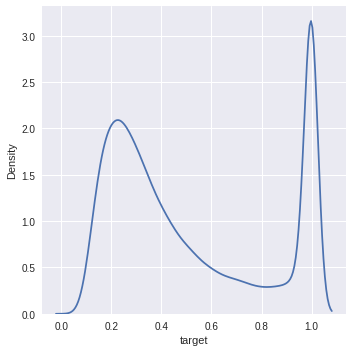

In [29]:
# Predict on test set and save to submission file
if Config.MODEL_PREDICT:
    preds_test = model.predict(test_ds, batch_size = Config.BATCH_SIZE_TEST, 
                               steps = spe_test, verbose = 1)

    sub_df = pd.DataFrame({
        "id": test_ids,
        "target": preds_test.flatten()
    })

    sub_df = sub_df.sort_values("id").reset_index(drop = True)
        
    sub_df.to_csv(Config.PREDICTIONS_NAME, index = False)

    plt.style.use("seaborn")
    print()
    print("Test dataset output distribution")
    sns.displot(sub_df, x = "target", kind = "kde")

Now let's try to break down the model into its constituent parts and plot the intermediate data for a single example. You might see that, depending on the example, visually identifying a merger chirp becomes difficult or even impossible mainly due other low and high frequency sources of noise (in this case simulated).

In [30]:
if Config.PLOT_EXAMPLE:

    permute = model.get_layer("permute")
    window = model.get_layer("window")
    bandpass = model.get_layer("bandpass")
    cqt = model.get_layer("cqt")
    resize = model.get_layer("resize")
    permute = model.get_layer("permute")
    mask_t = model.get_layer("mask_t")
    mask_f = model.get_layer("mask_f")
    effnet = model.get_layer(Config.MODEL_ID)
    flatten = model.get_layer("flatten")
    dense = model.get_layer("dense")
        
    if Config.PLOT_TEST:
        for data, _ in test_ds.take(1):
            x_ref = data.numpy()[0, ...][np.newaxis, ...]
    else:
        for data, _ in training_ds.take(1):
            x_ref = data.numpy()[0, ...][np.newaxis, ...]

    x = np.squeeze(x_ref)
    y = x_ref
        
    y = window(y)
    y_win = np.squeeze(y.numpy())
    y = bandpass(y)
    y_band = np.squeeze(y.numpy())
    y = cqt(y, training = False)
    y = resize(y)
    y_spec = np.squeeze(y.numpy())
    y = permute(y, training = True)

    for _ in range(Config.N_MAX_MASK):
        y = mask_t(y, training = True)
    for _ in range(Config.N_MAX_MASK):
        y = mask_f(y, training = True)

    y_masked = np.squeeze(y.numpy())
    y = effnet(y)
    y = flatten(y)
    y = dense(y)
    y_dense = np.squeeze(y.numpy())

Standardised signals


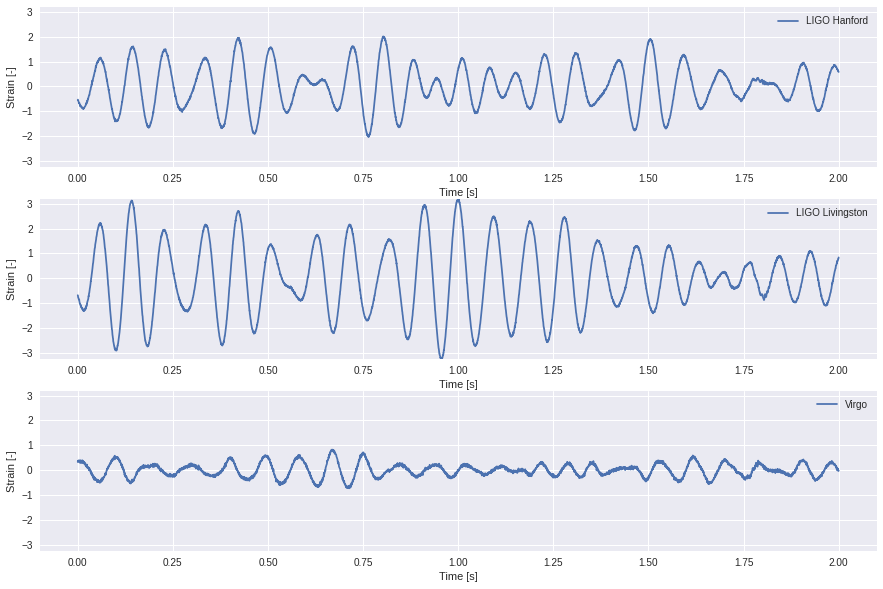

In [31]:
if Config.PLOT_EXAMPLE:
    print("Standardised signals")
    PlottingUtilities.plot_wave(x)

Tappered signals


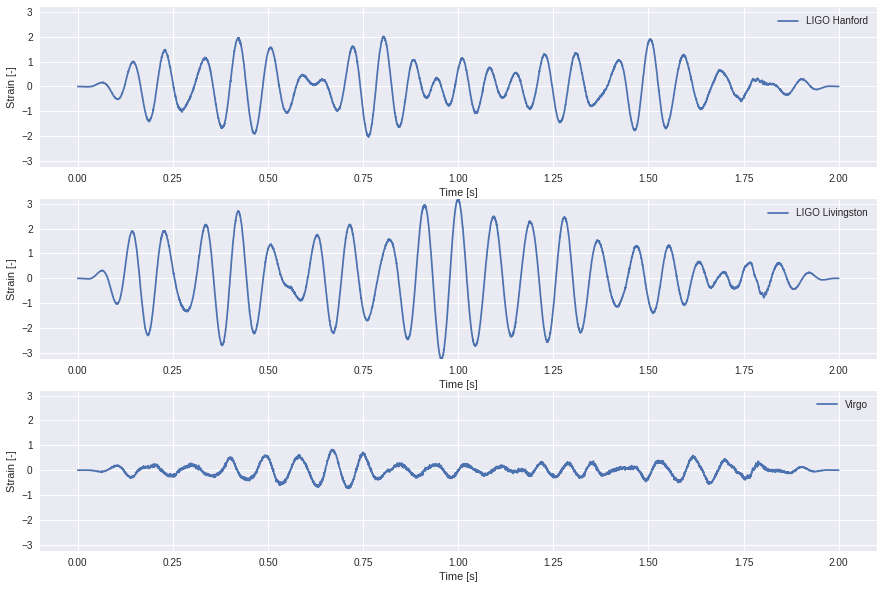

In [32]:
if Config.PLOT_EXAMPLE:
    print("Tappered signals")
    PlottingUtilities.plot_wave(y_win)

Filtered signals


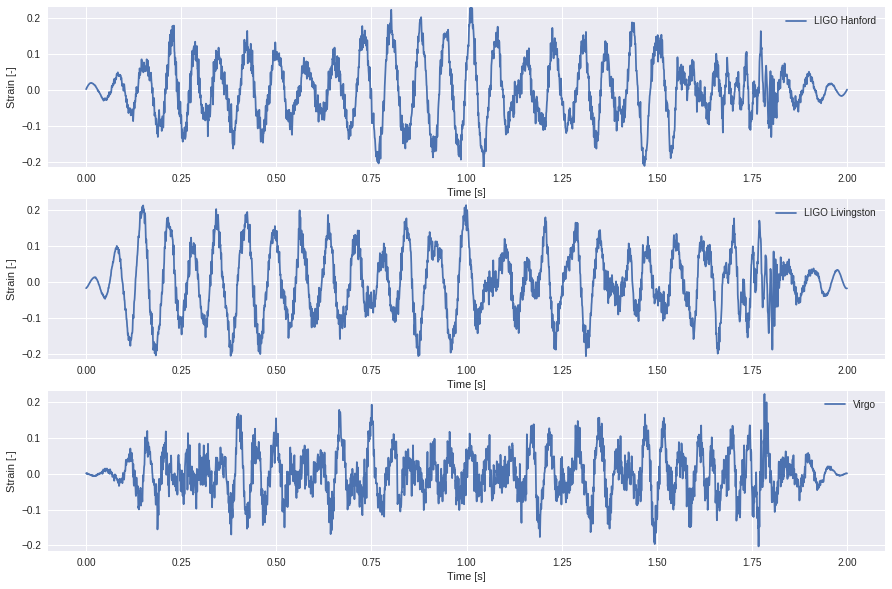

In [33]:
if Config.PLOT_EXAMPLE:
    print("Filtered signals")
    PlottingUtilities.plot_wave(y_band)

CQT spectrogram


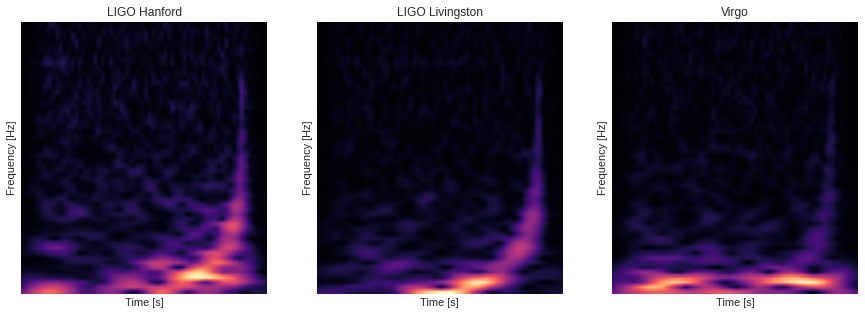

In [34]:
if Config.PLOT_EXAMPLE:
    print("CQT spectrogram")
    PlottingUtilities.plot_spectrogram(y_spec)

Masked CQT spectrogram


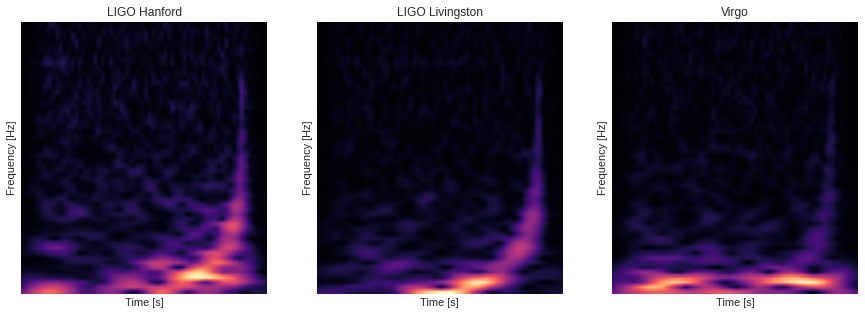

In [35]:
if Config.PLOT_EXAMPLE:
    print("Masked CQT spectrogram")
    PlottingUtilities.plot_spectrogram(y_masked)

Don't forget to save the results to your Google Drive! Make sure you have enough space as some models are truly heavy.

In [36]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
os.environ["OUT_NAME"] = "g2net_output"
!echo $OUT_NAME
!mkdir -p $OUT_NAME
!cp -r checkpoints $OUT_NAME
!cp -r models $OUT_NAME
!cp -r *.csv $OUT_NAME
!cp -r $OUT_NAME /content/gdrive/MyDrive/
drive.flush_and_unmount()

Mounted at /content/gdrive
g2net_output



The best G2Net single model was obtained with trainable Tukey window and bandpass layers, a non-trainable CQT, a resize size of 384, an EfficientNet v2 S backbone and training in a Tesla V100 (16GB) GPU with a batch size of 32 (learning rates in the range 0.0003 to 0.00001. The score was boosted with an averaging ensemble of several models with different settings. 

The ROC & Roll team encourages you to play with the code, propose improvements and even introduce new layers that might be of use!